In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import json
import random
import statistics
import numpy as np
import matplotlib.pyplot as plt
import requests

from rtree import index
from utils import *

In [2]:
place_name = "Singapore, Central, Singapore"
G = ox.save_load.load_graphml(filename="Singapore_drive_processed.graphml")

# Stores nodes and edges mapped with speed bands along with other attributes
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [3]:
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
nodes = pd.read_pickle('data/nodes_drive.pkl')

In [4]:
f = open("../../Traffic speed bands/Fri Feb 14 09_06_16 2020.json", "r").read()
x = json.loads(f)

speed_bands = pd.DataFrame.from_dict(x, orient='columns')
process_speed_band(speed_bands)

/home/orionstar25/Semester-8-Major-Project/Open Street Maps/Numerical Experiments/utils.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MaximumSpeed'][i] = '80'


In [5]:
calculate_congestion(G, edges, speed_bands)

In [6]:
# Filter out all bus stop nodes
# key: node label ,value: location
idx = index.Index()

xx = nodes['x'].astype(float)
yy = nodes['y'].astype(float)
node_id = nodes['osmid']
node_type = nodes['highway']

# nan = 18823

# speed_camera = 2
# motorway_junction = 222
# turning_circle = 79
# crossing = 27
# turning_loop = 26
# mini_roundabout = 6
# traffic signals = 4031

for node, x, y, kind in zip(node_id, xx, yy, node_type):
    if type(kind) == float:
      idx.insert(int(node), (x,y,x,y))

In [7]:
def find_nearest_nodes(nodes, source, dist, idx):
    # Create a bounding box around source of min distance in all directions
    (north, south, east, west) = ox.bbox_from_point(point=source, distance=dist)
    
    candidate_nodes = []
    initial = list(idx.intersection((west, south, east, north)))   
    for node in initial:
      x = haversine_distance(nodes, node, source)
      if x <= dist:
        candidate_nodes.append(node)

    return candidate_nodes

In [8]:
def get_length_dict(sources, destinations):
    distances = dict()
  
    for source in sources:        
        for dest in destinations:
            ed = haversine_distance(nodes, source, dest)
            distances[source,dest] = ed/13.8889
       
    # sort the dictionary in ascending order using distances
    x = sorted(distances.items(), key = lambda kv:(kv[1], kv[0]))
    return x    

## Hybrid Algorithm

In [9]:
def hybrid_search(G, x):
    n = len(x)
    min_pair = x[0]
    source = min_pair[0][0]
    dest = min_pair[0][1]
    min_tt = float('inf')
    final_route = []
    count = 0

    for i in range(n):
        try:
            source_x = nodes[nodes['osmid'] == source]['x'].values[0]
            source_y = nodes[nodes['osmid'] == source]['y'].values[0]
            dest_x = nodes[nodes['osmid'] == dest]['x'].values[0]
            dest_y = nodes[nodes['osmid'] == dest]['y'].values[0]
            
            url = "http://0.0.0.0:5000/route/v1/driving/{},{};{},{}".format(source_x, source_y, dest_x, dest_y)
            r = requests.get(url)
            json = r.json()
            
            travel_time = json['routes'][0]['weight']
            count = count + 1
        except nx.NetworkXUnfeasible:
            continue

        if travel_time < min_tt:
            min_tt = travel_time
            min_pair = x[i]

            if i < n-1:
                if travel_time < x[i+1][1]:
                    break
                else:
                    source = x[i+1][0][0]
                    dest = x[i+1][0][1]
            else:
                break
        else:
            if i < n-1:
                if min_tt < x[i+1][1]:
                    break
                else:
                    source = x[i+1][0][0]
                    dest = x[i+1][0][1]
            else:
                break

    return min_tt, count

## Modified Hybrid Search (n/e+1)

In [10]:
def modified_hybrid_search(G, x):
    n = len(x)
    cutoff = math.floor(n/math.exp(1))
    print(cutoff)
    min_pair = x[0]
    source = min_pair[0][0]
    dest = min_pair[0][1]
    min_tt = float('inf')
    count = 0

    for i in range(n):
        try:
            source_x = nodes[nodes['osmid'] == source]['x'].values[0]
            source_y = nodes[nodes['osmid'] == source]['y'].values[0]
            dest_x = nodes[nodes['osmid'] == dest]['x'].values[0]
            dest_y = nodes[nodes['osmid'] == dest]['y'].values[0]
            
            url = "http://0.0.0.0:5000/route/v1/driving/{},{};{},{}".format(source_x, source_y, dest_x, dest_y)
            r = requests.get(url)
            json = r.json()
            
            travel_time = json['routes'][0]['weight']
            count = count + 1
        except nx.NetworkXUnfeasible:
            continue

        # have reached cutoff and didnt find optimal yet
        if i > cutoff:
            if travel_time < min_tt:
                min_tt = travel_time
                min_pair = x[i]
                break
            else:
                break
        else:
            if travel_time < min_tt:
                min_tt = travel_time
                min_pair = x[i]

                if i < n-1:
                    if travel_time < x[i+1][1]:
                        break
                    else:
                        source = x[i+1][0][0]
                        dest = x[i+1][0][1]
                else:
                    break
            else:
                if i < n-1:
                    if min_tt < x[i+1][1]:
                        break
                    else:
                        source = x[i+1][0][0]
                        dest = x[i+1][0][1]
                else:
                    break

    return min_tt, count

### Calculate number of queries and deviation of travel times

In [11]:
def lets_do_this():
    # get 10 random sources
    sources = []
    for i in range(50):
        r = random.randint(0,23210)
        s = nodes['osmid'].values[r]
        sources.append(s)

    # get 10 correspondig random targets
    targets = []
    for i in range(50):
        r = random.randint(0,23210)
        t = nodes['osmid'].values[r]
        targets.append(t)

    mod_hybrid_q = []
    mod_hybrid_t = []
    hybrid_q = []
    hybrid_t = []
    exhaustive_q = []
  
    for s,t in zip(sources,targets):
        orig_point = nodes[nodes['osmid'] == s].geometry.values[0]
        target_point = nodes[nodes['osmid'] == t].geometry.values[0]
        orig_xy = (orig_point.y, orig_point.x)
        target_xy = (target_point.y, target_point.x)

        # Max distance for walking is 720m (10 min * 1.2 m/s)
        # Find all nodes within 720 m from candidate sources and candidate destinations
        candidate_dest = find_nearest_nodes(nodes, target_xy, 500, idx)
        candidate_source = find_nearest_nodes(nodes, orig_xy, 500, idx)

        if len(candidate_dest) == 0:
            candidate_dest.append(ox.get_nearest_node(G, target_xy))
      
        if len(candidate_source) == 0:
            candidate_source.append(ox.get_nearest_node(G, orig_xy))

        value = len(candidate_dest) * len(candidate_source)
        print(s,t,value)
        exhaustive_q.append(value)

        euclidean = get_length_dict(candidate_source, candidate_dest)
        value1_t, value1_q = hybrid_search(G, euclidean)
        hybrid_t.append(value1_t)
        hybrid_q.append(value1_q)
        
        value2_t, value2_q = modified_hybrid_search(G, euclidean)
        mod_hybrid_t.append(value2_t)
        mod_hybrid_q.append(value2_q)

    return mod_hybrid_q, mod_hybrid_t, hybrid_q, hybrid_t, exhaustive_q

In [12]:
mod_hybrid_q, mod_hybrid_t, hybrid_q, hybrid_t, exhaustive = lets_do_this()

401518869 6703954123 4056
1492
247749689 4733003100 1562
574
3067114709 2708140604 4482
1648
419832608 3106501867 6314
2322
206256158 237296695 5846
2150
2927544665 2618496852 2397
881
206089912 4612331160 425
156
6053707014 1199539791 2448
900
4598978568 1307501557 936
344
1411348485 4600485786 765
281
2391354934 1867272466 1462
537
6805732397 5189193324 2366
870
243713557 6257251194 897
329
247658398 4591817550 3922
1442
378612865 244131855 540
198
6491801769 1363297015 8484
3121
1119647353 5218422733 2262
832
2604187060 246629734 1312
482
5015699339 3054875049 2376
874
7108056547 7117912454 20227
7441
246580902 246960843 2332
857
4668479523 5189193324 624
229
4602245716 246175093 1120
412
244963671 7168049100 2950
1085
1740970587 682927642 1196
439
5272221495 4598827399 3132
1152
2523841754 249797272 693
254
1531170860 237170391 4588
1687
2327164424 419832586 2550
938
7053400923 439228231 1155
424
4607076208 392680106 2232
821
375767150 3063321303 3055
1123
4592883245 1387646699 189

## Deviation between travel times calculated by hybrid and modified hybrid

In [20]:
deviations = []
for h, mod_h in zip(hybrid_t, mod_hybrid_t):
#     stddev = statistics.stdev([h, mod_h])
    stddev = mod_h - h
    deviations.append(stddev)

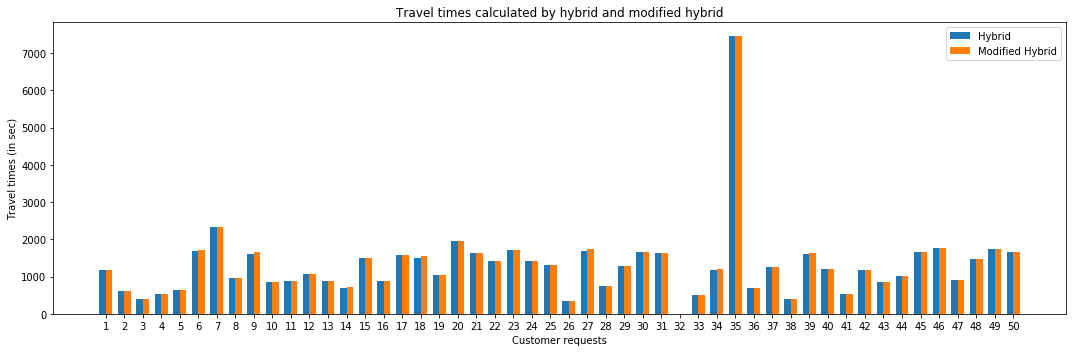

In [21]:
# Plot what hybrid gave and what modified hybrid gave
labels = [x for x in range(1,51)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/2, hybrid_t, width, label='Hybrid')
rects2 = ax.bar(x + width/2, mod_hybrid_t, width, label='Modified Hybrid')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Travel times (in sec)')
ax.set_xlabel('Customer requests')
ax.set_title('Travel times calculated by hybrid and modified hybrid')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

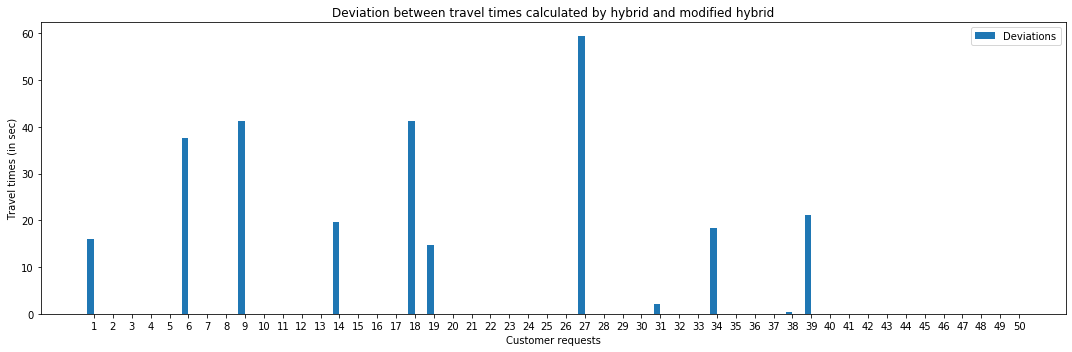

In [22]:
labels = [x for x in range(1,51)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/2, deviations, width, label='Deviations')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Travel times (in sec)')
ax.set_xlabel('Customer requests')
ax.set_title('Deviation between travel times calculated by hybrid and modified hybrid')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

In [23]:
print("Average deviation in secs:", statistics.mean(deviations))

Average deviation in secs: 5.43600000000001


## Number of queries

In [17]:
print("Number of queries")
print("Exhaustive   ||    Hybrid    ||    Modified Hybrid   ||    Saved% (Ex-Hyb)   ||    Saved% (Ex-Mod)")

hyb = []
mod = []
for e,h,m in zip(exhaustive, hybrid_q, mod_hybrid_q):
    saved_hyb = ((e-h)/e)*100
    hyb.append(saved_hyb)
    saved_mod = ((e-m)/e)*100
    mod.append(saved_mod)

    print(e, "              ", h,"              ",m, "            ",saved_hyb,"           ",saved_mod)

Number of queries
Exhaustive   ||    Hybrid    ||    Modified Hybrid   ||    Saved% (Ex-Hyb)   ||    Saved% (Ex-Mod)
4056                4056                1494              0.0             63.165680473372774
1562                1562                576              0.0             63.124199743918055
4482                4482                1650              0.0             63.186077643908966
6314                6314                2324              0.0             63.19290465631929
5846                5846                2152              0.0             63.18850496065686
2397                2397                883              0.0             63.16228619107217
425                425                158              0.0             62.82352941176471
2448                395                395              83.86437908496733             83.86437908496733
936                936                346              0.0             63.034188034188034
765                765                283      

In [18]:
print("Average numbers of queries saved for modified hybrid%:", statistics.mean(mod))

Average numbers of queries saved for modified hybrid%: 64.12090301158088


In [19]:
print("Average numbers of queries saved for hybrid%:", statistics.mean(hyb))

Average numbers of queries saved for hybrid%: 5.394442370101341
